In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import xgboost




from collections import Counter

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.head()

,student_id,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,pretest
0,W20C6,GOOBU,Urban,Public,HKF,Standard,28.0,Female,Qualifies for reduced/free lunch,34.0
1,A3JJP,GOOBU,Urban,Public,W8A,Experimental,26.0,Female,Qualifies for reduced/free lunch,36.0
2,UBDCF,DNQDD,Suburban,Public,PW5,Experimental,20.0,Male,Qualifies for reduced/free lunch,42.0
3,QQJEC,GOOBU,Urban,Public,W8A,Experimental,26.0,Female,Qualifies for reduced/free lunch,36.0
4,3SWL5,UUUQX,Suburban,Non-public,SSP,Standard,15.0,Female,Does not qualify,66.0


In [4]:
train.shape


(1706, 10)

In [5]:
numerical_feats = train.dtypes[train.dtypes != "object"].index 
print("Number of numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index 
print("Number of categorical features: ", len(categorical_feats))

Number of numerical features:  2
Number of categorical features:  8


In [6]:
corr_df = train.corr()
corr_df = corr_df.apply(lambda x: round(x, 2))
corr_df


,n_student,pretest
n_student,1.00,-0.49
pretest,-0.49,1.00


In [7]:
for catg in  list(categorical_feats) :
    print(train[catg].value_counts())
    print('-'*50)

B3Q7F    1
5H30M    1
M4RHA    1
G3900    1
MIMX1    1
        ..
B9J7D    1
LYT0H    1
YV3L0    1
ZAH4F    1
46P8Y    1
Name: student_id, Length: 1706, dtype: int64
--------------------------------------------------
GOOBU    129
QOQTS    119
DNQDD    101
UKPGS    100
GJJHK     95
VVTVA     92
ZOWMK     92
KZKKE     91
CUQAM     85
CCAAW     81
VKWQH     81
IDGFP     76
UAGPU     70
UUUQX     67
OJOBU     63
CIMBB     60
GOKXL     55
ZMNYA     55
LAYPA     44
VHDHF     43
KFZMY     43
FBUMG     36
ANKYI     28
Name: school, dtype: int64
--------------------------------------------------
Urban       724
Suburban    569
Rural       413
Name: school_setting, dtype: int64
--------------------------------------------------
Public        1272
Non-public     434
Name: school_type, dtype: int64
--------------------------------------------------
18K    26
A93    25
BFY    25
2AP    25
ZBH    25
       ..
J6X    12
AE1    12
JGD    12
EPS    10
197     9
Name: classroom, Length: 97, dtype: int64

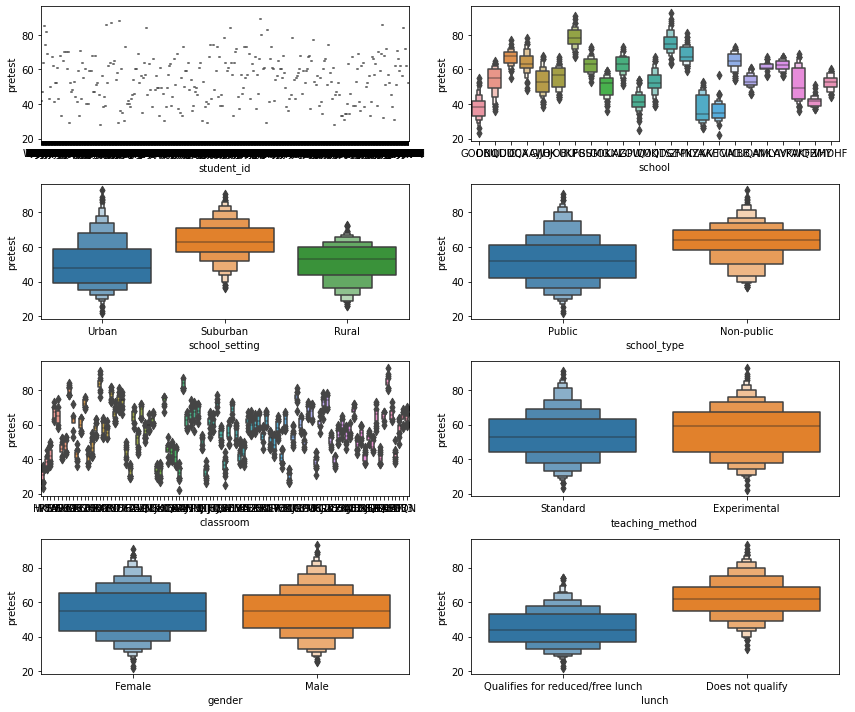

In [8]:
li_cat_feats = list(categorical_feats)
nr_rows = 4
nr_cols = 2

fix, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*6,nr_cols*5))

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxenplot(x=li_cat_feats[i], y=train['pretest'], data=train, ax=axs[r][c])

plt.tight_layout()
plt.show()


In [9]:
num_strong_corr = ['pretest']

num_weak_corr = ['n_student']

catg_strong_corr = ['lunch', 'school', 'classroom', 'school_setting']

catg_weak_corr = ['gender', 'teaching_method']

C:\Users\lhy99\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 0.066233
Kurtosis: -0.621219


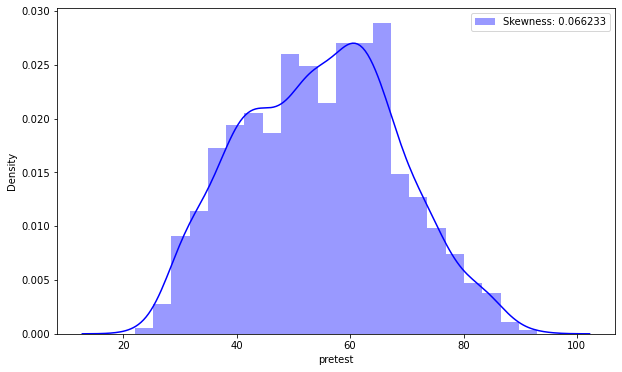

In [10]:
f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(train["pretest"], color = "b", label="Skewness: {:2f}".format(train["pretest"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % train["pretest"].skew())
print("Kurtosis: %f" % train["pretest"].kurt())


In [11]:
std_id_test = test['student_id']

to_drop_num = num_weak_corr
to_drop_catg = catg_weak_corr

cols_to_drop = ['student_id'] + to_drop_num + to_drop_catg

for df in [train, test]:
    df.drop(cols_to_drop, inplace = True, axis = 1)


In [12]:
train.head()

,school,school_setting,school_type,classroom,lunch,pretest
0,GOOBU,Urban,Public,HKF,Qualifies for reduced/free lunch,34.0
1,GOOBU,Urban,Public,W8A,Qualifies for reduced/free lunch,36.0
2,DNQDD,Suburban,Public,PW5,Qualifies for reduced/free lunch,42.0
3,GOOBU,Urban,Public,W8A,Qualifies for reduced/free lunch,36.0
4,UUUQX,Suburban,Non-public,SSP,Does not qualify,66.0


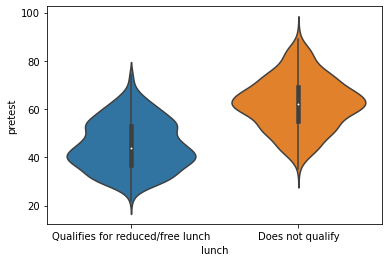

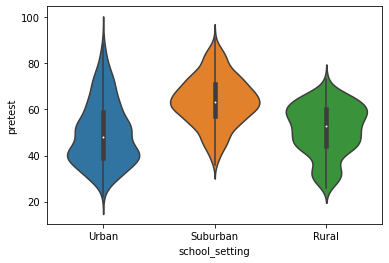

In [13]:
catg_list = catg_strong_corr.copy()
long_feats = ['school', 'classroom']
catg_list.remove('school')
catg_list.remove('classroom')
for catg in catg_list :
    sns.violinplot(x=catg, y=train['pretest'], data=train)
    plt.show()

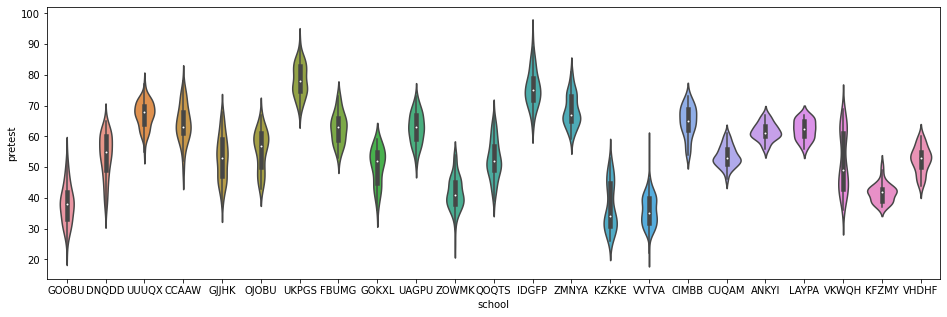

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(16,5)
sns.violinplot(x='school', y=train['pretest'], data=train, ax=ax)
plt.show()

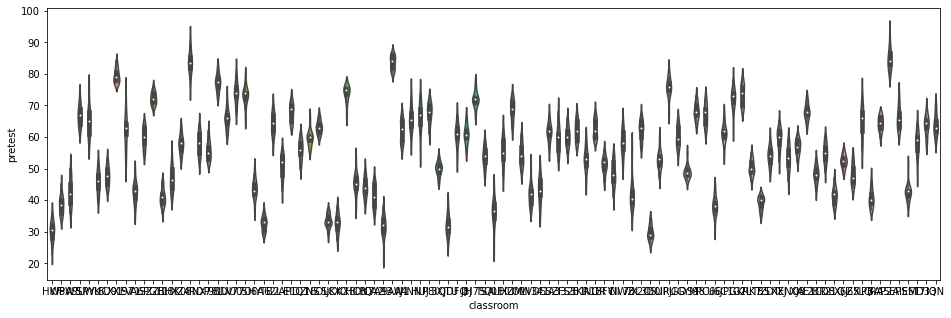

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(16,5)
sns.violinplot(x='classroom', y=train['pretest'], data=train, ax=ax)
plt.show()

In [16]:
y = train.pretest
X = train.drop(['pretest'], axis=1)

In [17]:
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
object_cols

['school', 'school_setting', 'school_type', 'classroom', 'lunch']

In [18]:
label_X = X.copy()
label_test = test.copy()

ordinal_encoder = OrdinalEncoder()
label_X[object_cols] = ordinal_encoder.fit_transform(X[object_cols])
label_test[object_cols] = ordinal_encoder.transform(test[object_cols])

In [19]:
label_X.head()

,school,school_setting,school_type,classroom,lunch
0,8.0,2.0,1.0,45.0,1.0
1,8.0,2.0,1.0,83.0,1.0
2,4.0,1.0,1.0,65.0,1.0
3,8.0,2.0,1.0,83.0,1.0
4,17.0,1.0,0.0,73.0,0.0


In [20]:
label_test.head()

,school,school_setting,school_type,classroom,lunch
0,18.0,0.0,0.0,53.0,1.0
1,6.0,1.0,1.0,95.0,1.0
2,2.0,2.0,0.0,62.0,0.0
3,7.0,0.0,1.0,82.0,1.0
4,14.0,2.0,1.0,15.0,0.0


In [21]:
X_train, X_val, y_train, y_val = train_test_split(label_X, y, test_size=0.2, random_state=3)

In [22]:
params ={
    'n_estimators':[10,50,100],
    'max_depth':[1,2,3,6,8,10,12,16,18,20],
    'min_samples_leaf':[1,2,4,8,12,18],
    'min_samples_split':[1,2,4,8,16,20]
}

In [52]:
RFG_model = RandomForestRegressor(max_depth=14, min_samples_leaf=1, min_samples_split=3, n_estimators=2550, random_state=0, n_jobs=-1)
#grid_cv = GridSearchCV(RFG_model, param_grid=params, cv=2, n_jobs=-1)
#grid_cv.fit(X_train, y_train)
RFG_model.fit(X_train, y_train)
#LightBGM
#LGBM_model = LGBMRegressor()
#LGBM_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, min_samples_split=3, n_estimators=2550,
                      n_jobs=-1, random_state=0)

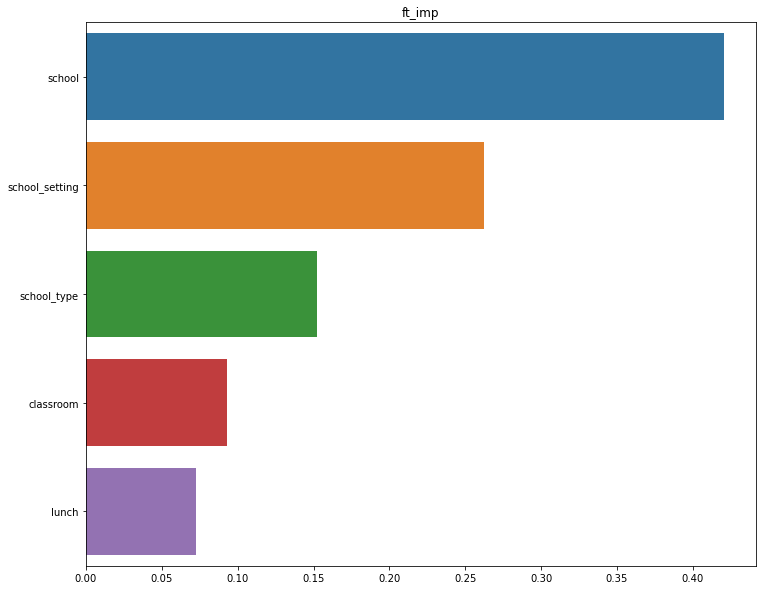

In [56]:
feature_imp = RFG_model.feature_importances_

ft_imp = pd.Series(feature_imp, index = X_train.columns)
ft_imp = ft_imp.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
plt.title("ft_imp")
sns.barplot(x=ft_imp, y= X_train.columns)
plt.show()

In [53]:
pred = RFG_model.predict(X_val)
mean_absolute_error(pred, y_val)

2.6366987592185835

In [25]:
RFG_result = RFG_model.predict(label_test)


In [28]:
pred_rfg = RFG_model.predict(label_test)

submission = pd.DataFrame()

submission['student_id'] = std_id_test
submission['pretest'] = pred_rfg

submission.to_csv('ssas.csv',index=False)




